Example showing how we model the time around the peak with a GPR and then use collocaiton to connect the inspiral and ringdown to it.

In [2]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import prim.waveform
import prim.waveform_generator
import prim.collocation

import lalsimulation as lalsim

import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, RationalQuadratic, Matern, DotProduct

In [253]:
wf_dict = prim.waveform_generator.generate_waveform(2, [(2,2), (2,1), (3,3)], approximant=lalsim.IMRPhenomTPHM, deltaT=1/4096/2/2)

In [254]:
wf_dict.keys()

dict_keys(['t', 'hlm'])

In [255]:
waveform = prim.waveform.Waveform(wf_dict['t'], wf_dict['hlm'])

In [256]:
waveform.compute_amplitude()

In [257]:
waveform.times

array([-1652.51119488, -1652.26336109, -1652.0155273 , ...,
         499.18179903,   499.42963283,   499.67746662])

In [258]:
waveform.times.shape

(8685,)

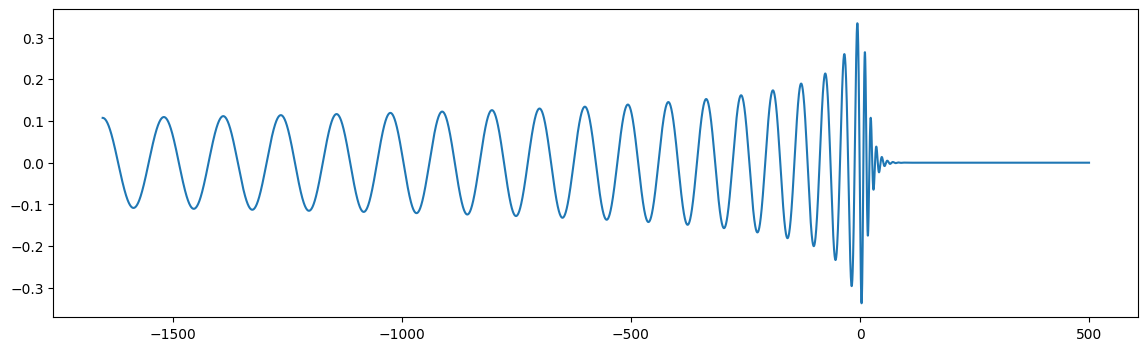

In [259]:
plt.figure(figsize=(14, 4))
plt.plot(waveform.times, waveform.hlms[(2,2)].real)

In [288]:
mask = (waveform.times > -100)  & (waveform.times < 30)

gpr_model = GaussianProcessRegressor(kernel=RBF(), alpha=1e-4)
gpr_model.fit(waveform.times[mask][:,np.newaxis], waveform.amplitudes[2,2][mask])

GaussianProcessRegressor(alpha=0.0001, kernel=RBF(length_scale=1))

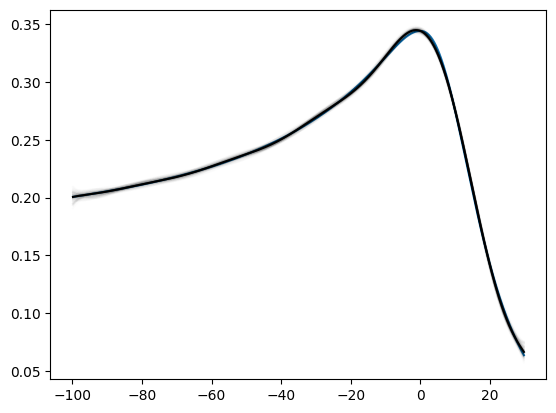

In [289]:
plt.plot(waveform.times[mask], waveform.amplitudes[2,2][mask][:,np.newaxis])
plt.plot(waveform.times[mask], gpr_model.sample_y(waveform.times[mask][:,np.newaxis], 100), alpha=0.01, color='k');
plt.plot(waveform.times[mask], gpr_model.predict(waveform.times[mask][:,np.newaxis]), color='k');

In [290]:
import sympy
x_sym = sympy.symbols('x_sym')


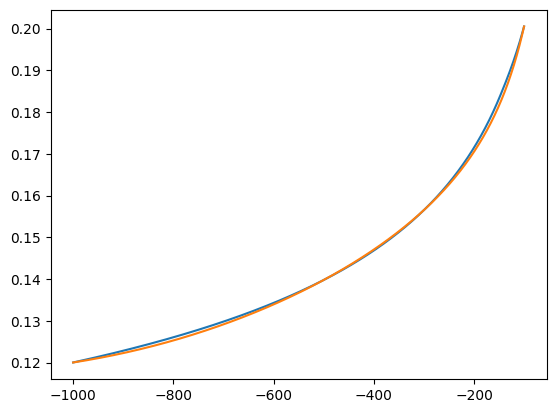

In [291]:
collocation_points = {0:[-1000, -500, -300, -100]}
collocation_values = prim.collocation.compute_values(collocation_points, waveform.times, waveform.amplitudes[2,2])
ansatz = 1 + 1/x_sym + x_sym + x_sym**2
cm = prim.collocation.CollocationModel(collocation_points, collocation_values, ansatz)

mask_ins = (waveform.times > -1000)  & (waveform.times < -100)
plt.plot(waveform.times[mask_ins], waveform.amplitudes[2,2][mask_ins])
plt.plot(waveform.times[mask_ins], cm.predict(waveform.times[mask_ins]))
# plt.xlim(-1000, 0)
# plt.ylim(0, 0.2)

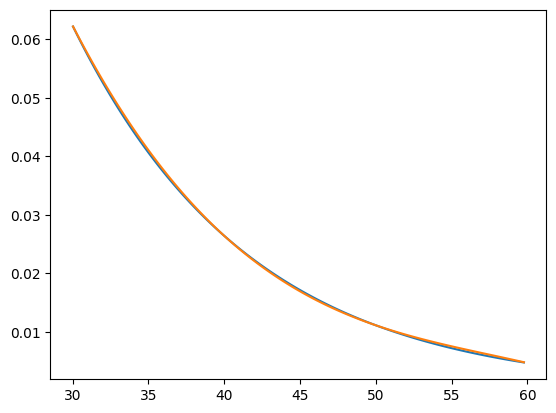

In [292]:
collocation_points = {0:[30, 40, 50, 60]}
collocation_values = prim.collocation.compute_values(collocation_points, waveform.times, waveform.amplitudes[2,2])
ansatz = 1 + x_sym + x_sym**2 + x_sym**3
cm = prim.collocation.CollocationModel(collocation_points, collocation_values, ansatz)

mask_rd = (waveform.times > 30) & (waveform.times < 60)
plt.plot(waveform.times[mask_rd], waveform.amplitudes[2,2][mask_rd])
plt.plot(waveform.times[mask_rd], cm.predict(waveform.times[mask_rd]))
# plt.xlim(-1000, 0)
# plt.ylim(0, 0.2)
# plt.yscale('log')

In [293]:
collocation_values

{0: [array(0.06238263),
  array(0.02644758),
  array(0.01114452),
  array(0.00469113)]}

In [294]:
# sample the merger model
# extract the model prediction at t=30 (the first point for the collocation model (technically we would have to interpolate to get this value or get the point closest to this if it's not on the grid. I guess there would be a resampling step... to the desired sample rate))
gpr_samples = gpr_model.sample_y(waveform.times[mask][:,np.newaxis], 30)
y_samples = gpr_samples[-1,:]

In [295]:
waveform.times[mask][-1]

29.784594416942756

In [296]:
gpr_samples[-1,:]

array([0.06737336, 0.06990264, 0.07085092, 0.07491961, 0.07128855,
       0.07440432, 0.06649574, 0.07045317, 0.07005555, 0.07400059,
       0.06800976, 0.07471924, 0.07057937, 0.07135715, 0.06097927,
       0.06772685, 0.06874009, 0.06495733, 0.06821512, 0.06259109,
       0.06748997, 0.06048811, 0.06196188, 0.06754063, 0.06217092,
       0.06639189, 0.06586054, 0.07382025, 0.07171448, 0.06554567])

In [297]:
y_samples

array([0.06737336, 0.06990264, 0.07085092, 0.07491961, 0.07128855,
       0.07440432, 0.06649574, 0.07045317, 0.07005555, 0.07400059,
       0.06800976, 0.07471924, 0.07057937, 0.07135715, 0.06097927,
       0.06772685, 0.06874009, 0.06495733, 0.06821512, 0.06259109,
       0.06748997, 0.06048811, 0.06196188, 0.06754063, 0.06217092,
       0.06639189, 0.06586054, 0.07382025, 0.07171448, 0.06554567])

In [298]:
y_preds = []
for i in range(len(y_samples)):
    collocation_values[0][0] = y_samples[i]
    cm = prim.collocation.CollocationModel(collocation_points, collocation_values, ansatz)
    y_preds.append(cm.predict(waveform.times[mask_rd]))

(0.0, 0.2)

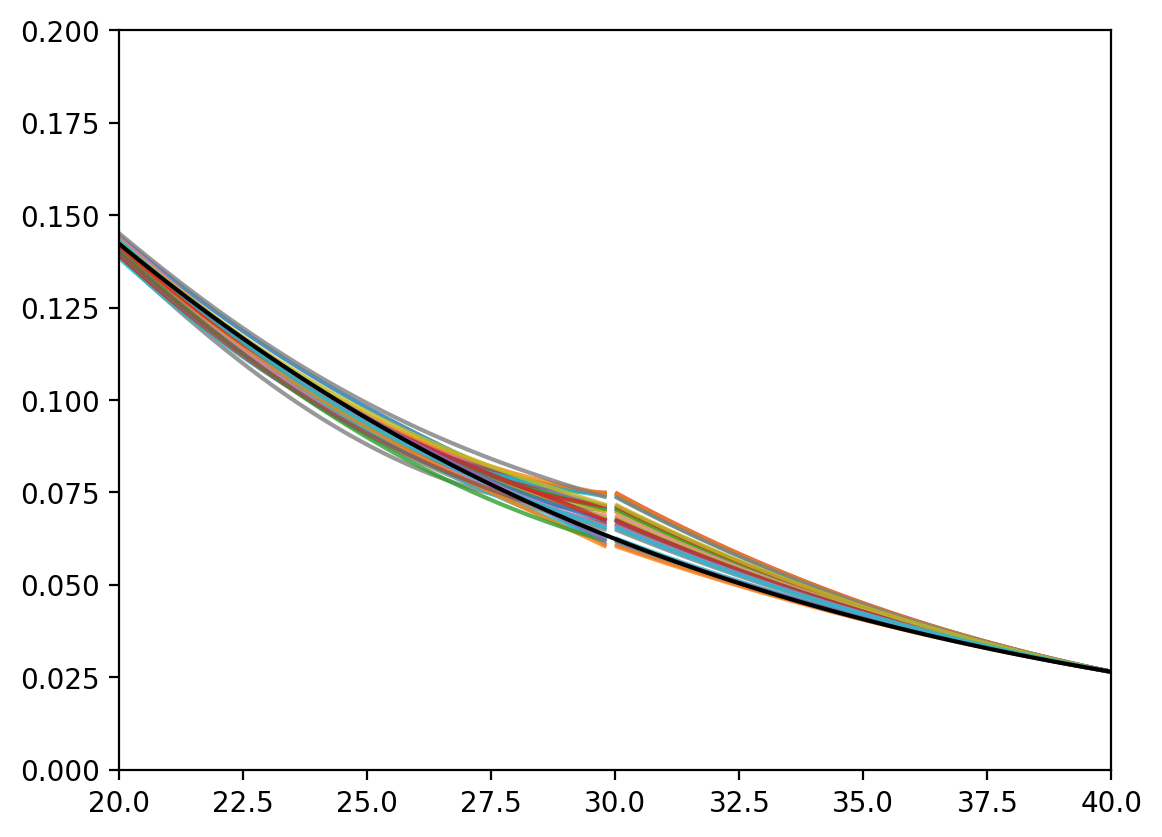

In [300]:
plt.figure(dpi=200)
plt.gca().set_prop_cycle(plt.rcParams['axes.prop_cycle'])
plt.plot(waveform.times[mask], gpr_samples, alpha=0.8);

plt.gca().set_prop_cycle(plt.rcParams['axes.prop_cycle'])
for i in range(len(y_samples)):
    plt.plot(waveform.times[mask_rd], y_preds[i], alpha=0.8)


plt.gca().set_prop_cycle(plt.rcParams['axes.prop_cycle'])
plt.plot(waveform.times, waveform.amplitudes[2,2], c='k')



# plt.xlim(-100, 100)
plt.xlim(20, 40)
plt.ylim(0,0.2)